In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
from tllib.ranking import negative_conditional_entropy as nce
from tllib.ranking import log_expected_empirical_prediction as leep

from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import paired_cosine_distances
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
from scipy.spatial import distance
from scipy.stats import entropy
from scipy.special import kl_div
from scipy.stats import pearsonr

from sklearn.metrics import mean_absolute_percentage_error

In [15]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div

def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

def compute_js_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the JS Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)
    
    list_of_tuples = support_intersection(p,q)
    p, q = get_probs(list_of_tuples)
    
    return js_divergence(p, q)

In [17]:
def mmd_linear(Sx, Sy, Tx, Ty):
            XX = np.dot(Sx, Tx)
            YY = np.dot(Sy, Ty)
            XY = np.dot(Sx, Ty)
            return XX.mean() + YY.mean() - 2 * XY.mean()

In [19]:
df = pd.DataFrame()

In [20]:
# kann eine Metrik verwendet werden um die Gleichheit der Regressions DF abzubinden ?
from sklearn.datasets import make_regression

# create features and targets
features, target = make_regression(n_samples=101, 
                                 n_features=100, 
                                 n_informative=10, 
                                 n_targets=1, 
                                 bias=0.0, 
                                 effective_rank=None, 
                                 tail_strength=0.2, 
                                 noise=0.0, 
                                 shuffle=True, 
                                 coef=False, 
                                 random_state=None)

df_1 = pd.DataFrame(features,target).reset_index(names="y")

# create features and targets
features, target = make_regression(n_samples=101, 
                                 n_features=100, 
                                 n_informative=10, 
                                 n_targets=1, 
                                 bias=0.0, 
                                 effective_rank=None, 
                                 tail_strength=0.2, 
                                 noise=0.0, 
                                 shuffle=True, 
                                 coef=False, 
                                 random_state=None)

df_2 = pd.DataFrame(features,target).reset_index(names="y")

list_percentage = np.arange(0, 101, 1).tolist()

list_results = []

for i in list_percentage:

    save_values = []
    save_values.append(i)

    df_combined = df_1[:101-i].append(df_2[101-i:])

    #Kullback-Leibler Divergenz
    kld = compute_kl_divergence(df_combined, df_2) # kl(df_combined, df_2).numpy()
    save_values.append(kld)
        
    #Euclidean Distance
    ed = euclidean_distances(df_combined, df_2).mean()
    save_values.append(ed)
        
    # Cosine Distances
    cd = paired_cosine_distances(df_combined,df_2).mean()
    save_values.append(cd)

    # Manhattan Distances
    md = manhattan_distances(df_combined,df_2).mean()
    save_values.append(md)

    # Wasserstein Distance
    was = wasserstein_distance(df_combined["y"],df_2["y"])
    save_values.append(was)

    # A-Distance
    x = 1#proxy_a_distance(df_1,df_2)
    save_values.append(x)

    # Ad-Distance
    ad = ks_2samp(df_combined["y"],df_2["y"])[0]
    save_values.append(ad)

    # Jensen Shannon
    js = compute_js_divergence(df_combined,df_2)
    save_values.append(js)

    # Pearson correlation coefficient
    cor = pearsonr(df_combined["y"],df_2["y"])[0]
    save_values.append(cor)

    # MMD
    mmd = mmd_linear(df_2,df_2["y"],df_combined,df_combined["y"])
    save_values.append(mmd)


    list_results.append(save_values)

#Visualize Sub-results
#fig, ax = plt.subplots(dpi=100)
#plt.scatter(df_combined["x"],df_combined["y"])

df = df.append(pd.DataFrame(list_results, columns =['Anteil','Kld', 'Ed', 'Cd', 'Md', 'Was', 'A', 'Ad','Js','Cor','Mmd']))

In [21]:
df_grouped = df.groupby(df.index).mean()
df_grouped

,Anteil,Kld,Ed,Cd,Md,Was,A,Ad,Js,Cor,Mmd
0,0.0,-0.030150,229.883492,0.983118,342.112192,36.294014,1.0,0.099010,0.007179,0.080224,3.566789e+05
1,1.0,-0.037301,228.283384,0.982985,340.495296,34.003145,1.0,0.089109,0.005501,0.076389,3.434509e+05
2,2.0,-0.035780,229.764224,0.982902,342.010799,36.331528,1.0,0.089109,0.005866,0.093092,4.191767e+05
3,3.0,-0.037104,230.169338,0.982826,342.304392,37.136256,1.0,0.089109,0.005524,0.096229,4.344635e+05
4,4.0,-0.017917,229.925161,0.982816,342.200778,36.881715,1.0,0.089109,0.005252,0.094296,4.253627e+05
...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,-0.007120,204.993884,0.057552,316.513981,11.061252,1.0,0.029703,0.000693,0.958134,3.195290e+06
97,97.0,-0.007422,204.614155,0.037773,316.143313,7.036981,1.0,0.019802,0.000615,0.981960,3.275998e+06
98,98.0,-0.007760,204.836926,0.019677,316.361490,5.637111,1.0,0.019802,0.000530,0.984817,3.293930e+06
99,99.0,0.001397,203.045433,0.019669,314.459885,3.745148,1.0,0.009901,0.000339,0.989311,3.248609e+06


In [ ]:
df_test = df.reset_index()

list_range = np.arange(0, len(df), 101).tolist()
print(list_range)

values =[]
for i in list_range:
    values.append(df["Anteil"][i:i+101].corr(df["Kld"][i:i+101]))
print(sum(values))
print(df["Anteil"].corr(df["Kld"]))

In [28]:
df

,Anteil,Kld,Ed,Cd,Md,Was,A,Ad,Js,Cor,Mmd
0,0,-0.030150,229.883492,0.983118,342.112192,36.294014,1,0.099010,0.007179,0.080224,3.566789e+05
1,1,-0.037301,228.283384,0.982985,340.495296,34.003145,1,0.089109,0.005501,0.076389,3.434509e+05
2,2,-0.035780,229.764224,0.982902,342.010799,36.331528,1,0.089109,0.005866,0.093092,4.191767e+05
3,3,-0.037104,230.169338,0.982826,342.304392,37.136256,1,0.089109,0.005524,0.096229,4.344635e+05
4,4,-0.017917,229.925161,0.982816,342.200778,36.881715,1,0.089109,0.005252,0.094296,4.253627e+05
...,...,...,...,...,...,...,...,...,...,...,...
96,96,-0.007120,204.993884,0.057552,316.513981,11.061252,1,0.029703,0.000693,0.958134,3.195290e+06
97,97,-0.007422,204.614155,0.037773,316.143313,7.036981,1,0.019802,0.000615,0.981960,3.275998e+06
98,98,-0.007760,204.836926,0.019677,316.361490,5.637111,1,0.019802,0.000530,0.984817,3.293930e+06
99,99,0.001397,203.045433,0.019669,314.459885,3.745148,1,0.009901,0.000339,0.989311,3.248609e+06


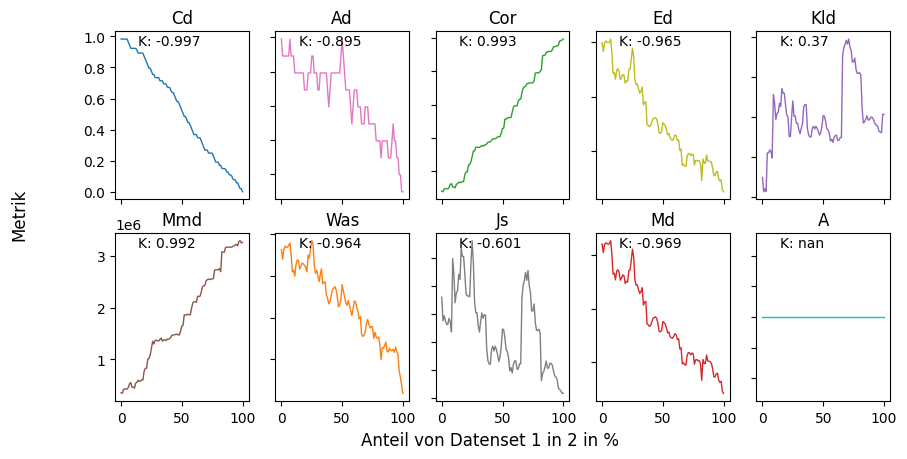

In [29]:
# Plot Metrics and d

metrics= ['Cd', 'Was', 'Cor', 'Md','Kld', 'Mmd', 'Ad', 'Js', 'Ed', 'A']
colours= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1f77b4']
hor= [0,1,2,3,4,0,1,2,3,4]
ver= [0,1,0,1,0,1,0,1,0,1]

fig, axs = plt.subplots(2, 5)

c = 0
for i in metrics:
    # Berechnung der Korrelation anhand der Schrittgröße 
    df_test = df.reset_index()
    list_range = np.arange(0, len(df), 101).tolist()
    values =[]

    for f in list_range:

        values.append(df["Anteil"][f:f+101].corr(df[i][f:f+101]))

    #print(values,sum(values)/len(values))
    #print("Mogel: ",df["Anteil"].corr(df[i]))

    axs[ver[c], hor[c]].plot(df_grouped["Anteil"], df_grouped[i], c=colours[c], label=i, linewidth=1)
    axs[ver[c], hor[c]].set_title(i)
    axs[ver[c], hor[c]].text(hor[c]*1.2-4.7, ver[c]*-1.2+2.15, 'K: '+str(round(sum(values)/len(values), 3)), transform=ax.transAxes)
    c+=1

fig.supxlabel('Anteil von Datenset 1 in 2 in %')
fig.supylabel('Metrik')
fig.set_figwidth(10) 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()